In [1]:
import numpy as np

In [2]:
#MNISTデータの読み込み
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

#訓練データとテストデータの取得
x_train = mnist.train.images
y_train = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels


#訓練データとテストデータのサイズ確認
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.
(55000, 784)
(55000, 10)
(10000, 784)
(10000, 10)


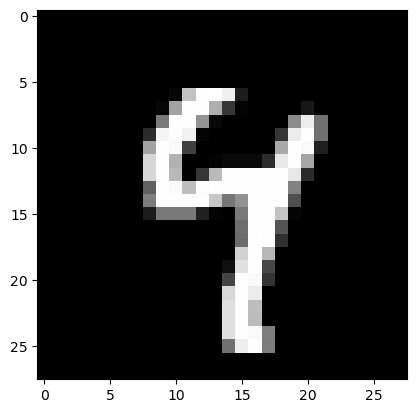

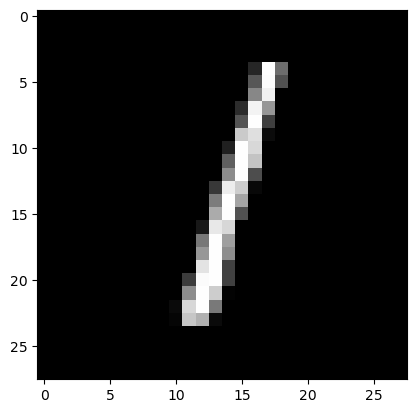

In [3]:
#訓練データとテストデータの画像確認
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_train[2].reshape(28, 28), cmap='gray')
plt.show()
plt.imshow(x_test[2].reshape(28, 28), cmap='gray')
plt.show()

In [4]:
#PReLU関数を定義
def prelu(z, alpha):
    """
    PReLU関数を定義

    入力:
        z -- 任意の大きさのnumpy配列
        alpha -- ハイパーパラメーター

    出力:
        a -- PReLU(z)
    """
    a = np.maximum(0, z) + alpha * np.minimum(0, z)

    return a

In [5]:
#softmax関数を定義
def softmax(Z):
    """
    softmax関数を定義

    入力:
        Z -- 任意の大きさのnumpy配列
        
    出力:
        A -- softmax(Z)
    """
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)

    return A

In [6]:
#PRelu関数の導関数を定義
def prelu_derivative(z, alpha):
    """
    PReLU関数の導関数を定義

    入力:
        z -- 任意の大きさのnumpy配列
        alpha -- ハイパーパラメーター

    出力:
        dz -- PReLU(z)的导数
    """
    dz = np.ones_like(z)
    dz[z < 0] = alpha

    return dz

In [7]:
#損失関数を定義
def cross_entropy(A, Y):
    """
    最小二乗法損失関数を定義

    入力:
        A -- softmax関数の出力
        Y -- 正解ラベル
    
    出力:
        loss -- 最小二乗法損失関数の値
    """
    m = Y.shape[0]
    loss = -np.sum(Y * np.log(A)) / m

    return loss

In [8]:
def initialize_weights(size_this, size_last):
    """
    重みを初期化する関数

    入力:
        size_this -- 現在の层的大きさ, 整型
        size_last -- 前の层的大きさ, 整型

    出力:
        weights -- 重みのnumpy配列
    """
    weights = np.random.randn(size_last,size_this) * 2.0 / size_last

    return weights



In [9]:
def initialize_bias(size_this, size_last):
    """
    偏置を初期化する関数

    入力:
        size_this -- 現在の层的大きさ, 整型
        size_last -- 前の层的大きさ, 整型

    出力:
        bias -- 偏置のnumpy配列
    """
    bias = np.zeros((size_this,1)) + 0.1

    return bias

In [10]:
def initialize_alpha():
    """
    PReLU関数のハイパーパラメーターを初期化する関数

    入力:
        无

    出力:
        alpha -- 初期化されたハイパーパラメーター
    """
    alpha = 0.01

    return alpha

In [11]:
def initialize_parameters(layers_size):
    """
    重みと偏置を初期化する関数

    入力:
        layers_size -- 各层的大きさ, 列表型

    返回:
        parameters -- 重みと偏置を保存する辞書
    """
    #層の数を取得
    num_layers = len(layers_size) - 1

    #辞書を初期化
    parameters = {}

    #重みと偏置を初期化
    for l in range(num_layers):
        parameters["W" + str(l+1)] = \
        initialize_weights(layers_size[l+1], layers_size[l])
        parameters["b" + str(l+1)] = \
        initialize_bias(layers_size[l+1], layers_size[l])
    
    #ハイパーパラメーターを初期化
    parameters["alpha"] = initialize_alpha()

    return parameters

In [12]:
#順伝播を定義
def forward_propagation(X, parameters):
    """
    順伝播を定義

    入力:
        X -- 入力データ, numpy配列, 形状は(入力サイズ, データ数)
        parameters -- パラメーターの辞書, {"Wl": Wl, "bl": bl, "alpha": alpha}

    出力:
        AL -- 出力層の出力
        caches -- 各層のキャッシュ, {"A0": X, "Z1": Z1, "A1": A1, ...}
    """

    #層の数を計算, 1層目は入力層なので除く
    num_layers = len(parameters) // 2

    #辞書を初期化
    caches = {}

    #入力層の出力を記録
    caches["A0"] = X

    #順伝播を計算
    for l in range(num_layers):
        #計算Zl
        caches["Z" + str(l+1)] = \
        np.dot(caches["A" + str(l)],parameters["W" + str(l+1)]) + \
        parameters["b" + str(l+1)].T

        #最終層以外は活性化関数を適用
        if l != num_layers - 1:
            caches["A" + str(l+1)] = prelu(caches["Z" + str(l+1)], parameters["alpha"])
        #最終層はsoftmax関数を適用
        else:
            caches["A" + str(l+1)] = softmax(caches["Z" + str(l+1)])

    #出力層の出力を記録
    AL = caches["A" + str(num_layers)]
    
    return AL, caches

In [13]:
#誤差逆伝播を定義
def backward_propagation(AL, Y, caches, parameters):
    """
    誤差逆伝播を定義

    入力:
        AL -- 出力層の出力
        Y -- 正解ラベル, numpy配列, 形状は(出力サイズ, データ数)
        caches -- 各層のキャッシュ, {"A0": X, "Z1": Z1, "A1": A1, ...}
    
    出力:
        grads -- 各パラメーターの勾配, {"dWl": dWl, "dbl": dbl, "alpha": alpha}

    """

 # 層の数を計算, 1層目は入力層なので除く
    num_layers = len(caches) // 2

# 勾配を初期化
    grads = {}

# 最終層のdZを計算
    grads["dZ" + str(num_layers)] = AL - Y

# 誤差逆伝播を計算
    for l in reversed(range(1, num_layers+1)):
    #dwlを求める
        grads["dW" + str(l)] = np.dot(grads["dZ" + str(l)].T, caches["A" + str(l-1)]) / AL.shape[0]
    
        grads["dW" + str(l)] = grads["dW" + str(l)].T

    #dbを求める
        grads["db" + str(l)] = np.sum(grads["dZ" + str(l)].T, axis=1, keepdims=True) / AL.shape[0]


    #dAl-1を求める
        if l > 1:
            grads["dA" + str(l-1)] = np.dot(grads["dZ" + str(l)],parameters["W" + str(l)].T)

    #dZl-1を求める
        if l > 1:
            grads["dZ" + str(l-1)] = grads["dA" + str(l-1)] * prelu_derivative(caches["Z" + str(l-1)], parameters["alpha"])

# dalphaを求める
    grads["dalpha"] = np.sum(grads["dZ" + str(1)] * (caches["Z" + str(1)] < 0)) / AL.shape[0]

    return grads

In [14]:
#パラメーターを更新
def update_parameters(parameters, grads, learning_rate):
    """
    パラメーターを更新

    入力:
        parameters -- パラメーターの辞書, {"Wl": Wl, "bl": bl, "alpha": alpha}
        grads -- 各パラメーターの勾配, {"dWl": dWl, "dbl": dbl, "alpha": alpha}
        learning_rate -- 学習率

    出力:
        parameters -- 更新後のパラメーターの辞書, {"Wl": Wl, "bl": bl, "alpha": alpha}
    """

    #層の数を計算, 1層目は入力層なので除く
    num_layers = len(parameters) // 2

    #パラメーターを更新
    for l in range(num_layers):
        parameters["W" + str(l+1)] = \
        parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = \
        parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    #alphaを更新
    parameters["alpha"] = \
    parameters["alpha"] - learning_rate * grads["dalpha"]

        

    return parameters


In [15]:
#正確率関数を定義
#ラベルの数が10個の場合, ALは(データ数, 10)の配列, Yは(データ数, 10)の配列
#この場合, ALの各行の最大値のインデックスを取得し, それがYの各行の最大値のインデックスと一致するかを確認する
def accuracy(AL, Y):
    """
    正確率関数を定義

    入力:
        AL -- 出力層の出力, numpy配列, 形状は(出力サイズ, データ数)
        Y -- 正解ラベル, numpy配列, 形状は(出力サイズ, データ数)
    
    出力:
        accuracy -- 正確率
    """

    #ALとYの最大値のインデックスを取得
    AL_max_index = np.argmax(AL, axis=1)
    Y_max_index = np.argmax(Y, axis=1)

    #正確率を計算
    accuracy = np.mean(AL_max_index == Y_max_index)

    return accuracy

In [16]:
#ハイパーパラメーターを設定
parameters = initialize_parameters([784,100,10])


In [17]:
#モデルを学習
for i in range(10000):
    #順伝播
    AL, caches = forward_propagation(x_train, parameters)

    #最小二乗法を用いて損失を計算
    cost = cross_entropy(AL, y_train)

    #逆伝播
    grads = backward_propagation(AL, y_train, caches, parameters)

    #パラメーターを更新
    #最初の30回は学習率を0.008に設定,以降は回数が増えるにつれて学習率を下げる
    if i < 30:
        parameters = update_parameters(parameters, grads, 0.008)
    elif i < 600:
        parameters = update_parameters(parameters, grads, 0.001)
    else:
        parameters = update_parameters(parameters, grads, 0.0002)

    # parameters = update_parameters(parameters, grads, 0.001)

    #10回ごとに損失と正確率を出力
    if i % 10 == 0:
        print("第" + str(i) + "回,损失は：" + str(cost))
        print("第" + str(i) + "回,正確率は:" + str(accuracy(AL, y_train)))
        #テストデータでの正確率を出力
        print("第" + str(i) + "回，テストデータの正解率は：" + str(accuracy(forward_propagation(x_test, parameters)[0], y_test)))

    #ファストストックホルダー法を用いてパラメーターを更新
    #最初の1回はリストを作成
    if i == 0:
        parameters_list = [parameters]
        accuracy_list = [accuracy(AL, y_train)]
    else:
        parameters_list.append(parameters)
        accuracy_list.append(accuracy(AL, y_train))

    #200回以上学習した後, 200回連続高い正解率が出なかったら学習を終了
    if i > 200:
        if np.all(accuracy_list[-200:] < np.max(accuracy_list)):
            break

第0回,损失は：10.914808332817836
第0回,正確率は:0.1346
第0回，テストデータの正解率は：0.1457
第10回,损失は：10.911188726367353
第10回,正確率は:0.3494181818181818
第10回，テストデータの正解率は：0.3641
第20回,损失は：10.907627948807978
第20回,正確率は:0.5255454545454545
第20回，テストデータの正解率は：0.5348
第30回,损失は：10.904213454652881
第30回,正確率は:0.6068
第30回，テストデータの正解率は：0.6067
第40回,损失は：10.903793592723666
第40回,正確率は:0.6131818181818182
第40回，テストデータの正解率は：0.616
第50回,损失は：10.903374695515788
第50回,正確率は:0.6189272727272728
第50回，テストデータの正解率は：0.6199
第60回,损失は：10.902956684544383
第60回,正確率は:0.6236
第60回，テストデータの正解率は：0.6243
第70回,损失は：10.902539462847669
第70回,正確率は:0.6280363636363636
第70回，テストデータの正解率は：0.6293
第80回,损失は：10.902122807248961
第80回,正確率は:0.6308909090909091
第80回，テストデータの正解率は：0.6329
第90回,损失は：10.901706492876617
第90回,正確率は:0.6344909090909091
第90回，テストデータの正解率は：0.6376
第100回,损失は：10.901290388747471
第100回,正確率は:0.638
第100回，テストデータの正解率は：0.6421
第110回,损失は：10.900874488864998
第110回,正確率は:0.6408
第110回，テストデータの正解率は：0.6445
第120回,损失は：10.900458643069141
第120回,正確率は:0.6435090909090909
第120回，テストデータの正解率は：0.6479
第13

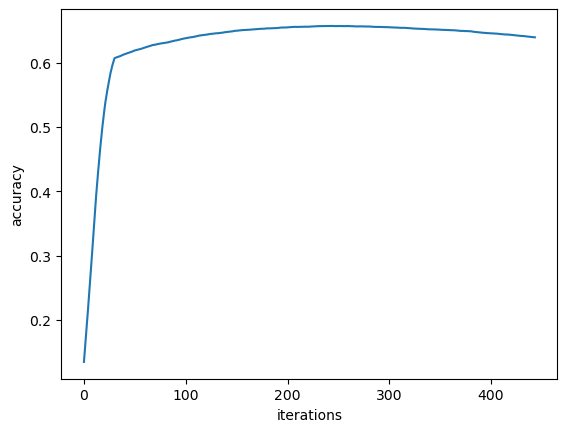

最高正解率：0.6571272727272728
最高准确率の回数：243


In [18]:
#正解率の推移をグラフに描画
plt.plot(accuracy_list)
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.show()
#最高正解率とその時のパラメーターを表示
print("最高正解率：" + str(np.max(accuracy_list)))
print("最高准确率の回数：" + str(np.argmax(accuracy_list)))